In [1]:
import numpy as np
import io
import os
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact
import copy
import re
import matplotlib.pyplot as plt
from tabulate import tabulate
from itertools import groupby

In [2]:
# importing all vcf files paths and storing them in three different lists depending on the group of the individuals

my_path = "/home/yboulkaid/Documents/sample_data/pgtest.data/calls/"
# my_path = "/Users/boulkaid/Documents/4A/pangenomes/pgtest.data/calls/"
all_vcf = os.listdir(my_path)
g0_vcf = []
g1_vcf = []
for i in all_vcf:
    if 'g0' in i:
        g0_vcf.append(i)
    elif 'g1' in i:
        g1_vcf.append(i)

In [3]:
# function to create a data frame from a vcf file

def make_vcf_df(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(io.StringIO(''.join(lines)),
                       dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str, 'QUAL': str, 'FILTER': str, 'INFO': str},
                       sep='\t').rename(columns={'#CHROM': 'CHROM'})

In [4]:
# creating three data frames for all vcfs, g0 and g1 vcfs

all_vcf_df = []
for i in all_vcf:
    all_vcf_df.append(make_vcf_df(my_path + i))

g0_vcf_df = []
for i in g0_vcf:
    g0_vcf_df.append(make_vcf_df(my_path + i))

g1_vcf_df = []
for i in g1_vcf:
    g1_vcf_df.append(make_vcf_df(my_path + i))

In [5]:
# annex function used later to create the "snarl data frames"

def chemins(which_vcf_df):
    chemins_possibles = []
    for i in range(len(which_vcf_df["INFO"])):
        text = which_vcf_df["INFO"][i]
        m = re.search('AT=>(.+?);DP', text)
        if m:
            found = m.group(1)
        chemins_possibles.append(found)

    for i in range(len(chemins_possibles)):
        chemins_possibles[i] = chemins_possibles[i].split(',')

    ########################################################################
    chemins_pris = []
    for i in which_vcf_df["SAMPLE"]:
        found = i[0:3]
        chemins_pris.append(found)

    for i in range(len(chemins_pris)):
        chemins_pris[i] = chemins_pris[i].split('/')
        for j in range(len(chemins_pris[i])):
            chemins_pris[i][j] = int(chemins_pris[i][j])

    ########################################################################
    chemins_combines = copy.deepcopy(chemins_pris)

    for i in range(len(chemins_pris)):
        chemins_combines[i][0] = chemins_possibles[i][chemins_pris[i][0]]
        chemins_combines[i][1] = chemins_possibles[i][chemins_pris[i][1]]

    chemins_possibles = sum(chemins_possibles, [])
    for i in range(len(chemins_possibles)):
        if chemins_possibles[i][0] == '>':
            chemins_possibles[i] = chemins_possibles[i][1:]
    chemins_pris = sum(chemins_pris, [])
    chemins_combines = sum(chemins_combines, [])
    for i in range(len(chemins_combines)):
        if chemins_combines[i][0] == '>':
            chemins_combines[i] = chemins_combines[i][1:]

    return chemins_possibles, chemins_pris, chemins_combines

In [6]:
# annex functions that detect the first and last node of a snarl

def start_node(which_snarl):
    if which_snarl[0] == '>':
        S = re.search('>(.+?)>', which_snarl)
        if S:
            s = S.group(1)
    else:
        S = re.search('(.+?)>', which_snarl)
        if S:
            s = S.group(1)
    return s


def end_node(which_snarl):
    if which_snarl[0] == '>':
        E = re.search('.+>(.*)', which_snarl)
        if E:
            e = E.group(1)
    else:
        E = re.search('.+>(.*)', which_snarl)
        if E:
            e = E.group(1)
    return e

In [7]:
# function to create a "snarl data frame" from a list of vcf data frames

def make_snarl_df(which_vcf_list):
    df = pd.DataFrame(columns=['snarl index', 'snarl', 'times taken', 'index provisoire'])

    chemins_possibles = [chemins(i)[0] for i in all_vcf_df]
    chemins_possibles = sum(chemins_possibles, [])
    chemins_possibles = list(set(chemins_possibles))
    for i in range(len(chemins_possibles)):
        df.loc[i, 'times taken'] = 0

    df['snarl'] = chemins_possibles

    combine_counts = []
    for i in range(len(which_vcf_list)):
        chemins_combines = chemins(which_vcf_list[i])[2]
        combine_counts.extend((x, chemins_combines.count(x)) for x in set(chemins_combines))

    snarl_dict = {str(snarl): index for index, snarl in enumerate(df['snarl'])}

    for snarl, count in combine_counts:
        if snarl in snarl_dict:
            df.loc[snarl_dict[snarl], "times taken"] += count

    # fill 'snarl index' column
    for i in range(len(df['snarl index'])):
        s = start_node(df['snarl'][i])
        e = end_node(df['snarl'][i])
        df.loc[i, "snarl index"] = s + '>' + e
        df.loc[i, "index provisoire"] = int(s)
        '''if df['snarl'][i][0] == '>':
            S = re.search('>(.+?)>', df['snarl'][i])
            if S:
                s = S.group(1)
            E = re.search('.+>(.*)', df['snarl'][i])
            if E:
                e = E.group(1)
            df.loc[i, "snarl index"] = s + '>' + e
            df.loc[i, "index provisoire"] = int(s)
        else:
            S = re.search('(.+?)>', df['snarl'][i])
            if S:
                s = S.group(1)
            E = re.search('.+>(.*)', df['snarl'][i])
            if E:
                e = E.group(1)
            df.loc[i, "snarl index"] = s + '>' + e
            df.loc[i, "index provisoire"] = int(s)'''

    df.set_index('index provisoire', inplace=True, drop=True)
    df.sort_index(inplace=True)
    df.reset_index()
    df.set_index('snarl index', inplace=True, drop=True)
    return df

In [8]:
# creating three data frames for all vcfs, g0 and g1 vcfs

all_df = make_snarl_df(all_vcf_df)
g0_df = make_snarl_df(g0_vcf_df)
g1_df = make_snarl_df(g1_vcf_df)

In [9]:
# functions used to perform the tests and compute the p-values

def make_table_contingence(which_snarl_df, which_g0_df, which_g1_df, which_snarl):
    n = which_snarl_df.index.value_counts()[which_snarl]
    chem = []
    for i in range(n):
        chem.append(which_g0_df.loc[which_snarl]['snarl'].iloc[i])
    df2 = pd.DataFrame(columns=['g0', 'g1'], index=chem)
    for i in range(len(chem)):
        df2.at[chem[i], 'g1'] = which_g1_df.loc[which_snarl]['times taken'].iloc[i]
        df2.at[chem[i], 'g0'] = which_g0_df.loc[which_snarl]['times taken'].iloc[i]
    return df2


make_table_contingence(all_df, g0_df, g1_df, '4>9')


def chi2(table):
    return chi2_contingency(table).pvalue


def fish(table):
    return fisher_exact(table, alternative='two-sided').pvalue 

In [10]:
# from a complete contingency table (ie. that takes all possible paths into account) obtain a simplified table that only two paths into account (the direct one and all other ones)
# ex: snarl 1>6, possible paths 1>6, 1>2>3>5>6, 1>2>4>5>6 become 1>6 and 1>2>*>5>6

def make_square_table(which_snarl_df, which_g0_df, which_g1_df, which_snarl):
    table = make_table_contingence(which_snarl_df, which_g0_df, which_g1_df, which_snarl)
    if len(table) > 2:
        others_g0 = others_g1 = direct_g0 = direct_g1 = 0
        for i in range(len(table)):
            if table.index[i] != which_snarl:
                others_g0 += table['g0'].iloc[i]
                others_g1 += table['g1'].iloc[i]
            else:
                direct_g0 = table['g0'].iloc[i]
                direct_g1 = table['g1'].iloc[i]

        # renaming the paths
        longest_path = max(table.index, key=len)
        S = re.search('(.+?>.+?)>', longest_path)
        if S:
            s = S.group(1)
        E = re.search('.+>(.+?>.*)', longest_path)
        if E:
            e = E.group(1)
        other = s + '> * >' + e
        
        # creating final table
        new_table = pd.DataFrame({'g0': [direct_g0, others_g0], 'g1': [direct_g1, others_g1]}, index=[which_snarl, other])
        return new_table
    else:
        return table

In [11]:
# computing the p-values for all snarls

pval_list_comp_chi2 = []  # celle avec tous les chemins possibles et test chi2
pval_list_part_chi2 = []  # celle avce les chemins simplifiés et test chi2
pval_list_part_fish = []  # celle avec les chemins simplifiés et test fisher

for i in all_df.index.unique():
    table = make_table_contingence(all_df, g0_df, g1_df, i)
    l = len(table)
    table_to_modify = table.copy(deep=True)
    ctr = 0
    mask = (table['g0'] == 0) & (table['g1'] == 0)
    table_to_modify = table_to_modify[~mask]
    pval_list_comp_chi2.append([chi2(table_to_modify), i])

for i in all_df.index.unique():
    table = make_square_table(all_df, g0_df, g1_df, i)
    l = len(table)
    table_to_modify = table.copy(deep=True)
    ctr = 0
    mask = (table['g0'] == 0) & (table['g1'] == 0)
    table_to_modify = table_to_modify[~mask]
    pval_list_part_chi2.append([chi2(table_to_modify), i])

pval_list_part_fish = [[fish(make_square_table(all_df, g0_df, g1_df, i)), i] for i in all_df.index.unique()]

# checking that all pval_lists are the same size
print(len(pval_list_comp_chi2) == len(pval_list_part_chi2) == len(pval_list_part_fish))

True


In [12]:
# function to create a p-value data frame from a list of p-values

seuil = 2


def make_pval_df(which_pval_list):
    pval_df = pd.DataFrame(columns=['snarl index', 'p-valeur', 'moinslog10pvaleur', 'color'])
    for i in range(len(which_pval_list)):
        pval_df.loc[i, 'snarl index'] = which_pval_list[i][1]
        pval_df.loc[i, "p-valeur"] = which_pval_list[i][0]
        if which_pval_list[i][0] != -1:
            pval_df.loc[i, "moinslog10pvaleur"] = -np.log10(which_pval_list[i][0])
        else:
            print('not ok')
    conditions = [(pval_df['moinslog10pvaleur'] == -0.0),
                  (pval_df['moinslog10pvaleur'] > seuil), 
                  (pval_df.index % 2 == 0)]
    choices = ['red', 'green', 'cyan']
    pval_df['color'] = np.select(conditions, choices, default='blue')
    pval_df.set_index('snarl index', inplace=True, drop=True)
    return pval_df

In [13]:
make_pval_df(pval_list_comp_chi2)

,p-valeur,moinslog10pvaleur,color
snarl index,,,
1>4,0.711884,0.147591,cyan
4>9,0.396877,0.401344,blue
9>12,0.741182,0.130075,cyan
12>14,0.180334,0.743923,blue
14>19,0.102512,0.989226,cyan
...,...,...,...
489>492,1.0,-0.0,red
492>497,0.027035,1.568072,cyan
497>502,0.054222,1.265821,blue


In [14]:
# creating the p-value data frames and getting the smallest p-values in the data frame

pval_df_comp_chi2 = make_pval_df(pval_list_comp_chi2)
smallest_pv_comp_chi2 = [(-np.log10(pval_list_comp_chi2[i][0]), pval_list_comp_chi2[i][1]) for i in range(len(pval_list_comp_chi2)) if -np.log10(pval_list_comp_chi2[i][0]) > seuil]
print('len (chi2, full paths) : ', len(smallest_pv_comp_chi2))
print(smallest_pv_comp_chi2)
print('\n')

pval_df_part_chi2 = make_pval_df(pval_list_part_chi2)
smallest_pv_part_chi2 = [(-np.log10(pval_list_part_chi2[i][0]), pval_list_part_chi2[i][1]) for i in range(len(pval_list_part_chi2)) if -np.log10(pval_list_part_chi2[i][0]) > seuil]
print('len (chi2, partial paths) : ', len(smallest_pv_part_chi2))
print(smallest_pv_part_chi2)
print('\n')

pval_df_part_fish = make_pval_df(pval_list_part_fish)
smallest_pv_part_fish = [(-np.log10(pval_list_part_fish[i][0]), pval_list_part_fish[i][1]) for i in range(len(pval_list_part_fish)) if -np.log10(pval_list_part_fish[i][0]) > seuil]
print('len (fisher, partial paths) : ', len(smallest_pv_part_fish))
print(smallest_pv_part_fish)

len (chi2, full paths) :  8
[(6.089961181235811, '79>84'), (2.624205309601664, '89>92'), (2.15176597063122, '170>173'), (2.6944204841540467, '204>239'), (3.1620872897202483, '242>245'), (4.743716244978902, '254>256'), (3.193545924964768, '427>438'), (3.1902936329226557, '446>449')]


len (chi2, partial paths) :  7
[(6.089961181235812, '79>84'), (2.624205309601664, '89>92'), (2.15176597063122, '170>173'), (3.1620872897202483, '242>245'), (4.743716244978902, '254>256'), (3.95320216004672, '427>438'), (3.1902936329226557, '446>449')]


len (fisher, partial paths) :  7
[(6.284338973538244, '79>84'), (2.675953573556851, '89>92'), (2.223904994202138, '170>173'), (3.214654995974976, '242>245'), (4.923029036003348, '254>256'), (4.648015799945936, '427>438'), (3.302108687348577, '446>449')]


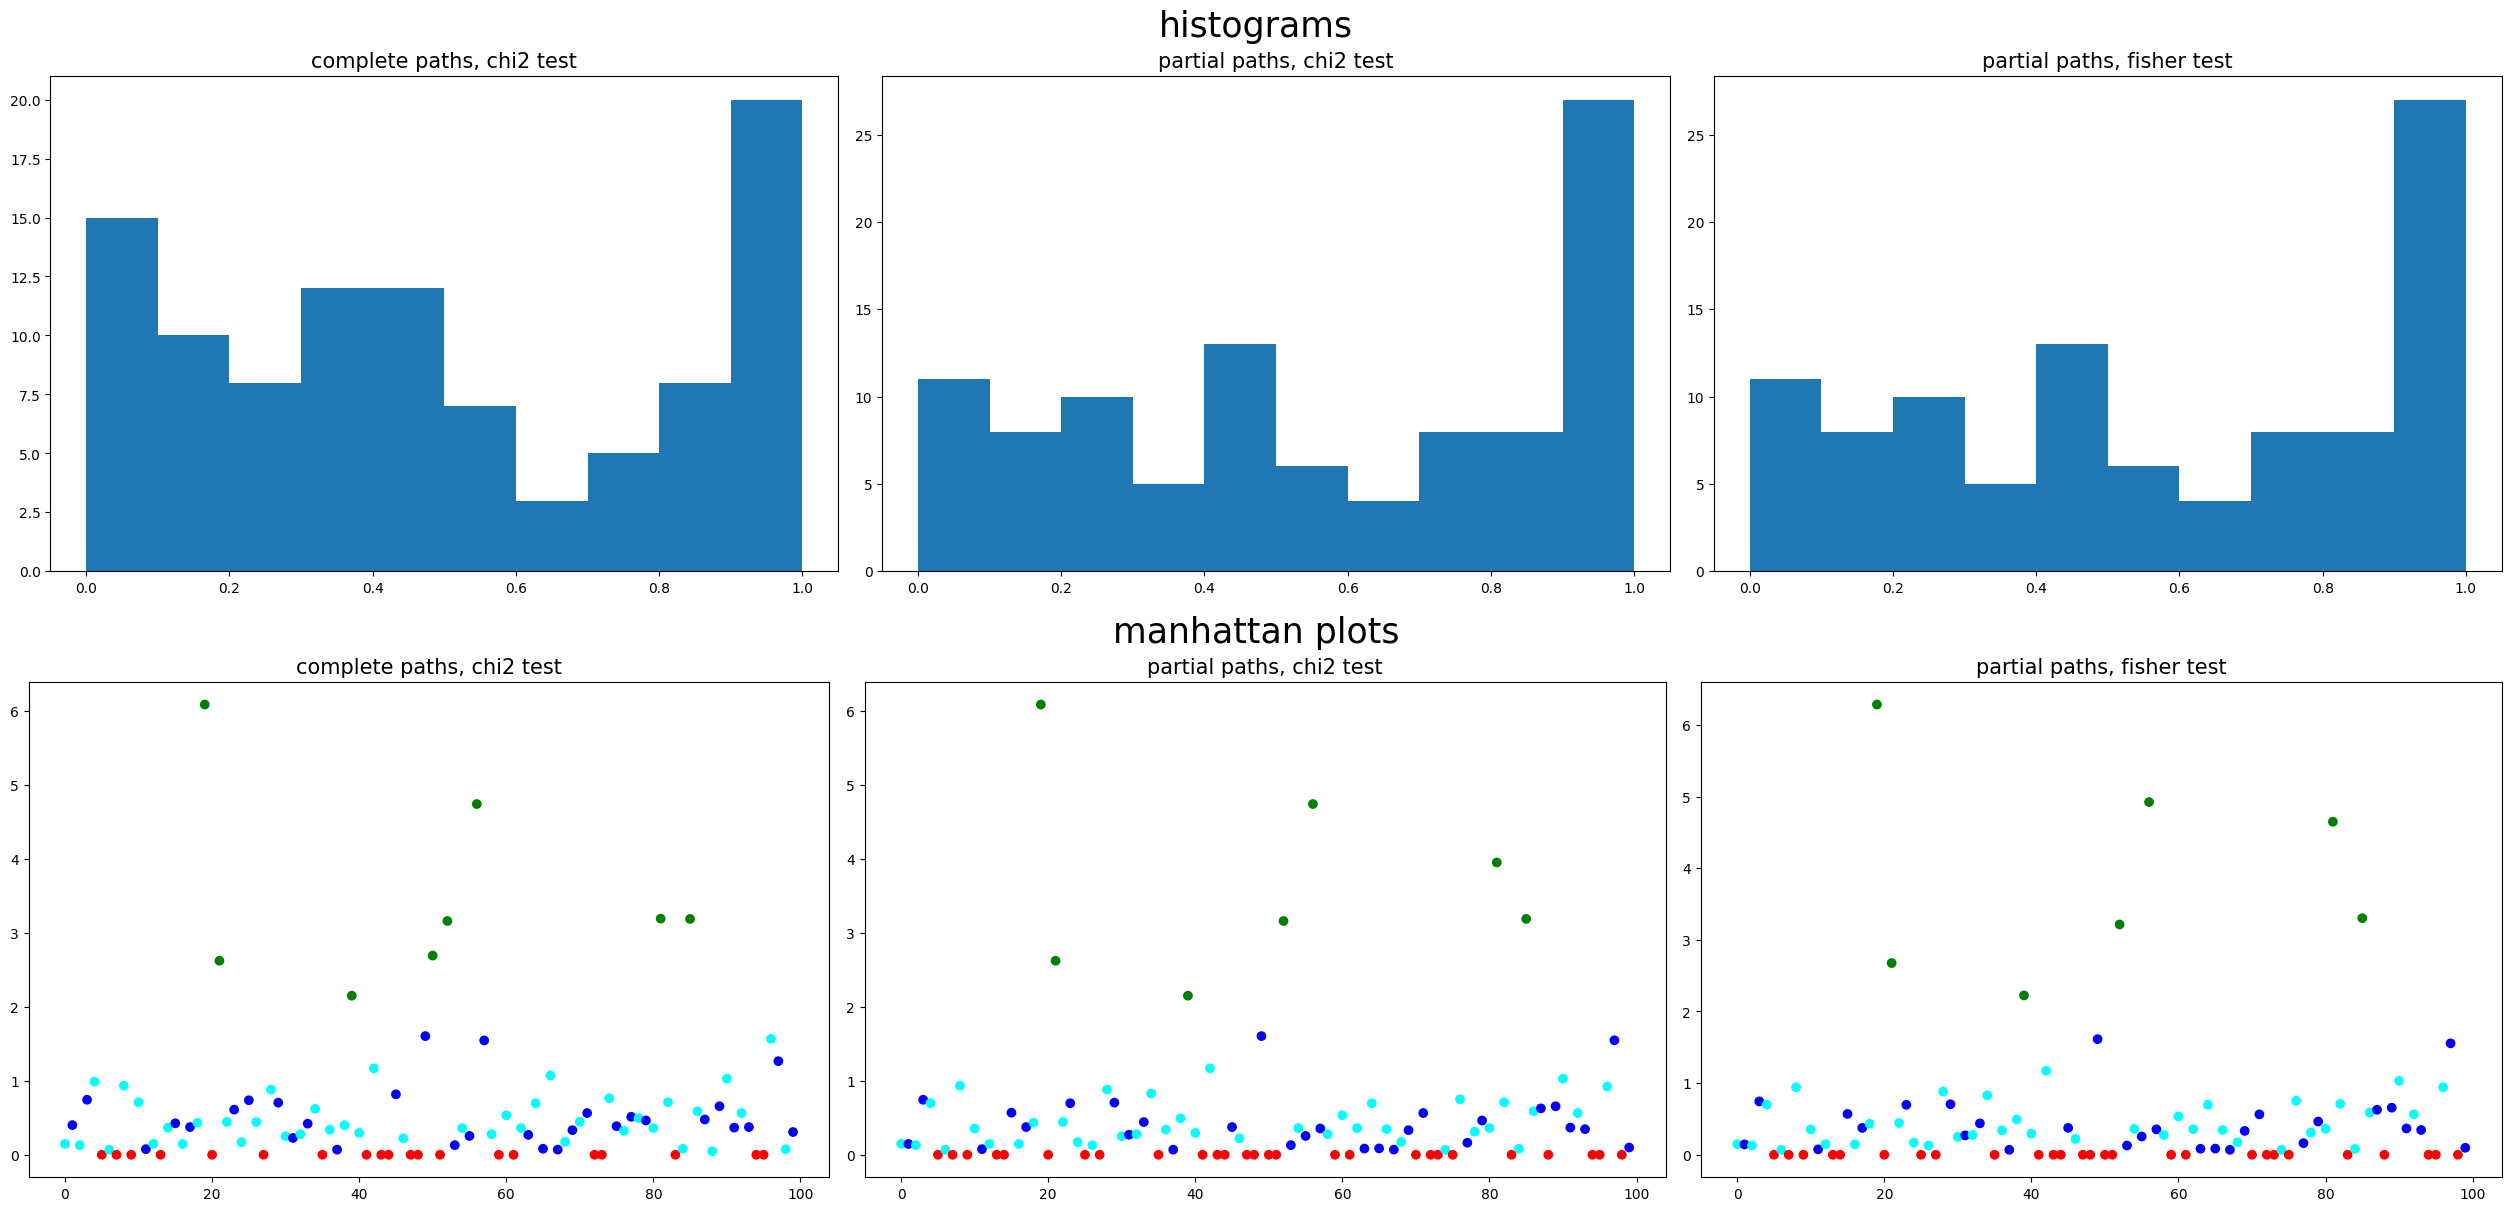

In [15]:
# histograms and manhattan plots

fig = plt.figure(constrained_layout=True)
fig.set_figheight(12)
fig.set_figwidth(25)
# fig.suptitle('Figure title')

subfig_titles = ['histograms', 'manhattan plots']
plot_titles = ['complete paths, chi2 test', 'partial paths, chi2 test', 'partial paths, fisher test']

subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfig_titles[row], fontsize=25)

    # Create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    if row == 0:
        # Add histograms to the first subfig
        axs[0].hist(pval_df_comp_chi2['p-valeur'])
        axs[1].hist(pval_df_part_chi2['p-valeur'])
        axs[2].hist(pval_df_part_fish['p-valeur'])
        # Set titles for the first row
        for col, ax in enumerate(axs):
            ax.set_title(plot_titles[col], fontsize=15)
    elif row == 1:
        # Add scatter plots to the second subfig
        axs[0].scatter(range(len(pval_df_comp_chi2)), pval_df_comp_chi2['moinslog10pvaleur'], c=pval_df_comp_chi2['color'])
        axs[1].scatter(range(len(pval_df_part_chi2)), pval_df_part_chi2['moinslog10pvaleur'], c=pval_df_part_chi2['color'])
        axs[2].scatter(range(len(pval_df_part_fish)), pval_df_part_fish['moinslog10pvaleur'], c=pval_df_part_fish['color'])
        for col, ax in enumerate(axs):
            ax.set_title(plot_titles[col], fontsize=15)

In [16]:
# function to verify that the sum of the columns in the contingency tables is always 60 (because we have 60 vcf files)

def contingence_somme_col(snarl_list):
    snarl_index_somme_pas_ok = []
    for i in snarl_list:
        if make_table_contingence(all_df, g0_df, g1_df, i).sum(axis=0).iloc[0] != 60 or make_table_contingence(all_df, g0_df, g1_df, i).sum(axis=0).iloc[1] != 60:
            snarl_index_somme_pas_ok.append(i)
        if make_square_table(all_df, g0_df, g1_df, i).sum(axis=0).iloc[0] != 60 or make_square_table(all_df, g0_df, g1_df, i).sum(axis=0).iloc[1] != 60:
            snarl_index_somme_pas_ok.append(i)

    if len(snarl_index_somme_pas_ok) == 0:
        print('bien ouej !')
    else:
        print('better luck next time...')


contingence_somme_col(all_df.index.unique())

bien ouej !


In [17]:
# size of all snarls and number of snarls for each size 
# ex: there are 66 snarls where only two paths are possible and 1 snarl with 61 possible paths

length_of_paths = []
for i in list(all_df.index):
    length_of_paths.append(list(all_df.index).count(i))

# occ = [[x,ind.count(x)] for x in set(ind)]

taille_chem = list(set(length_of_paths))
freq_taille = [len(list(group)) for key, group in groupby(sorted(length_of_paths))]
freq_taille = [int(freq_taille[i] / taille_chem[i]) for i in range(len(freq_taille))]

print(taille_chem, freq_taille)

[2, 3, 5, 7, 8, 9, 12, 13, 14, 16, 17, 61] [66, 19, 1, 2, 1, 2, 1, 1, 2, 3, 1, 1]


# Deuxième partie : linking the new tsv to the vcfs

In [18]:
bdsg = pd.read_csv('/home/yboulkaid/Documents/pg.snarl_netgraph.paths.tsv', sep='\t')
paths_list = bdsg['paths'].tolist()

chemins_possibles = [chemins(i)[0] for i in all_vcf_df]
chemins_possibles = sum(chemins_possibles, [])
chemins_possibles = list(set(chemins_possibles))

# on obtient une liste qui a la même structure que chemins_possibles
## on sépare les snarls pour que 1 element de la liste corresponde à 1 snarl
for i in range(len(paths_list)):
    paths_list[i] = paths_list[i].split(',')
paths_list = sum(paths_list, [])

## on supprime le premier caractère, qui est toujours '>'
for i in range(len(paths_list)):
    paths_list[i] = paths_list[i][1:]

# on cherche les start_nodes dans les deux listes
start_nodes_og = []
start_nodes_bdsg = []
for i in chemins_possibles:
    s = start_node(i)
    start_nodes_og.append(s)

for i in paths_list:
    s = start_node(i)
    start_nodes_bdsg.append(s)

# on trouve les nouveaux snarls ie. les snarls imbriqués dans d'autres snarls qu'on ne détéctait pas avant
new_start_index = []
for i in range((len(start_nodes_bdsg))):
    if start_nodes_bdsg[i] not in start_nodes_og:
        new_start_index.append(i)

new_snarls = [paths_list[i] for i in new_start_index][::-1]

# start_nodes_bdsg = list(map(int, set(start_nodes_bdsg)))
start_nodes_bdsg = list(set(map(int, start_nodes_bdsg)))

In [19]:
# mtn il faut faire le lien entre les nouveaux snarls et les vcf 

new_all_df = pd.DataFrame(columns=['snarl index', 'snarl', 'times taken', 'index provisoire'])

for i in range(len(new_snarls)):
    new_all_df.loc[i, 'times taken'] = 0

new_all_df['snarl'] = new_snarls

# fill 'snarl index' column
for i in range(len(new_all_df['snarl index'])):
    s = start_node(new_all_df['snarl'][i])
    e = end_node(new_all_df['snarl'][i])
    new_all_df.loc[i, "snarl index"] = s + '>' + e
    new_all_df.loc[i, "index provisoire"] = int(s)

new_all_df.set_index('index provisoire', inplace=True, drop=True)
new_all_df.sort_index(inplace=True)
new_all_df.reset_index()
new_all_df.set_index('snarl index', inplace=True, drop=True)

times_taken = [0] * len(new_all_df['snarl'])
for i in range(len(all_df['snarl'])):
    for j in range(len(new_all_df['snarl'])):
        if new_all_df['snarl'].iloc[j] in all_df['snarl'].iloc[i]:
            # print(new_all_df['snarl'].iloc[j],all_df['snarl'].iloc[i])
            times_taken[j] += all_df['times taken'].iloc[i]
            pass
new_all_df['times taken'] = times_taken

new_all_df

,snarl,times taken
snarl index,,
5>8,5>7>8,53
5>8,5>6>8,59
15>18,15>17>18,18
15>18,15>16>18,38
35>38,35>37>38,41
...,...,...
498>501,498>499>501,59
503>506,503>505>506,28
503>506,503>504>506,89


In [20]:
# mtn il faut faire le lien entre les nouveaux snarls et les vcf 

new_g0_df = pd.DataFrame(columns=['snarl index', 'snarl', 'times taken', 'index provisoire'])

for i in range(len(new_snarls)):
    new_g0_df.loc[i, 'times taken'] = 0

new_g0_df['snarl'] = new_snarls

# fill 'snarl index' column
for i in range(len(new_g0_df['snarl index'])):
    s = start_node(new_g0_df['snarl'][i])
    e = end_node(new_g0_df['snarl'][i])
    new_g0_df.loc[i, "snarl index"] = s + '>' + e
    new_g0_df.loc[i, "index provisoire"] = int(s)

new_g0_df.set_index('index provisoire', inplace=True, drop=True)
new_g0_df.sort_index(inplace=True)
new_g0_df.reset_index()
new_g0_df.set_index('snarl index', inplace=True, drop=True)

times_taken = [0] * len(new_g0_df['snarl'])
for i in range(len(all_df['snarl'])):
    for j in range(len(new_g0_df['snarl'])):
        if new_g0_df['snarl'].iloc[j] in g0_df['snarl'].iloc[i]:
            # print(new_all_df['snarl'].iloc[j],all_df['snarl'].iloc[i])
            times_taken[j] += g0_df['times taken'].iloc[i]
            pass
new_g0_df['times taken'] = times_taken

new_g0_df

,snarl,times taken
snarl index,,
5>8,5>7>8,23
5>8,5>6>8,32
15>18,15>17>18,5
15>18,15>16>18,19
35>38,35>37>38,16
...,...,...
498>501,498>499>501,36
503>506,503>505>506,14
503>506,503>504>506,45


In [21]:
# mtn il faut faire le lien entre les nouveaux snarls et les vcf 

new_g1_df = pd.DataFrame(columns=['snarl index', 'snarl', 'times taken', 'index provisoire'])

for i in range(len(new_snarls)):
    new_g1_df.loc[i, 'times taken'] = 0

new_g1_df['snarl'] = new_snarls

# fill 'snarl index' column
for i in range(len(new_g1_df['snarl index'])):
    s = start_node(new_g1_df['snarl'][i])
    e = end_node(new_g1_df['snarl'][i])
    new_g1_df.loc[i, "snarl index"] = s + '>' + e
    new_g1_df.loc[i, "index provisoire"] = int(s)

new_g1_df.set_index('index provisoire', inplace=True, drop=True)
new_g1_df.sort_index(inplace=True)
new_g1_df.reset_index()
new_g1_df.set_index('snarl index', inplace=True, drop=True)

times_taken = [0] * len(new_g1_df['snarl'])
for i in range(len(all_df['snarl'])):
    for j in range(len(new_g1_df['snarl'])):
        if new_g1_df['snarl'].iloc[j] in g1_df['snarl'].iloc[i]:
            # print(new_all_df['snarl'].iloc[j],all_df['snarl'].iloc[i])
            times_taken[j] += g1_df['times taken'].iloc[i]
            pass
new_g1_df['times taken'] = times_taken

new_g1_df

,snarl,times taken
snarl index,,
5>8,5>7>8,30
5>8,5>6>8,27
15>18,15>17>18,13
15>18,15>16>18,19
35>38,35>37>38,25
...,...,...
498>501,498>499>501,23
503>506,503>505>506,14
503>506,503>504>506,44


## here

In [22]:
pval_list_bdsg = []


for i in new_all_df.index.unique():
    table = make_table_contingence(new_all_df, new_g0_df, new_g1_df, i)
    l = len(table)
    table_to_modify = table.copy(deep=True)
    ctr = 0
    mask = (table['g0'] == 0) & (table['g1'] == 0)
    table_to_modify = table_to_modify[~mask]
    pval_list_bdsg.append([chi2(table_to_modify), i])

pval_df_bdsg = make_pval_df(pval_list_bdsg)
smallest_pv_bdsg = [(-np.log10(pval_list_bdsg[i][0]), pval_list_bdsg[i][1]) for i in range(len(pval_list_bdsg)) if -np.log10(pval_list_bdsg[i][0]) > seuil]
print('len (chi2, bdsg) : ', len(smallest_pv_bdsg))
print(smallest_pv_bdsg)

len (chi2, bdsg) :  2
[(4.2799156450403855, '226>229'), (2.145244483123026, '344>347')]


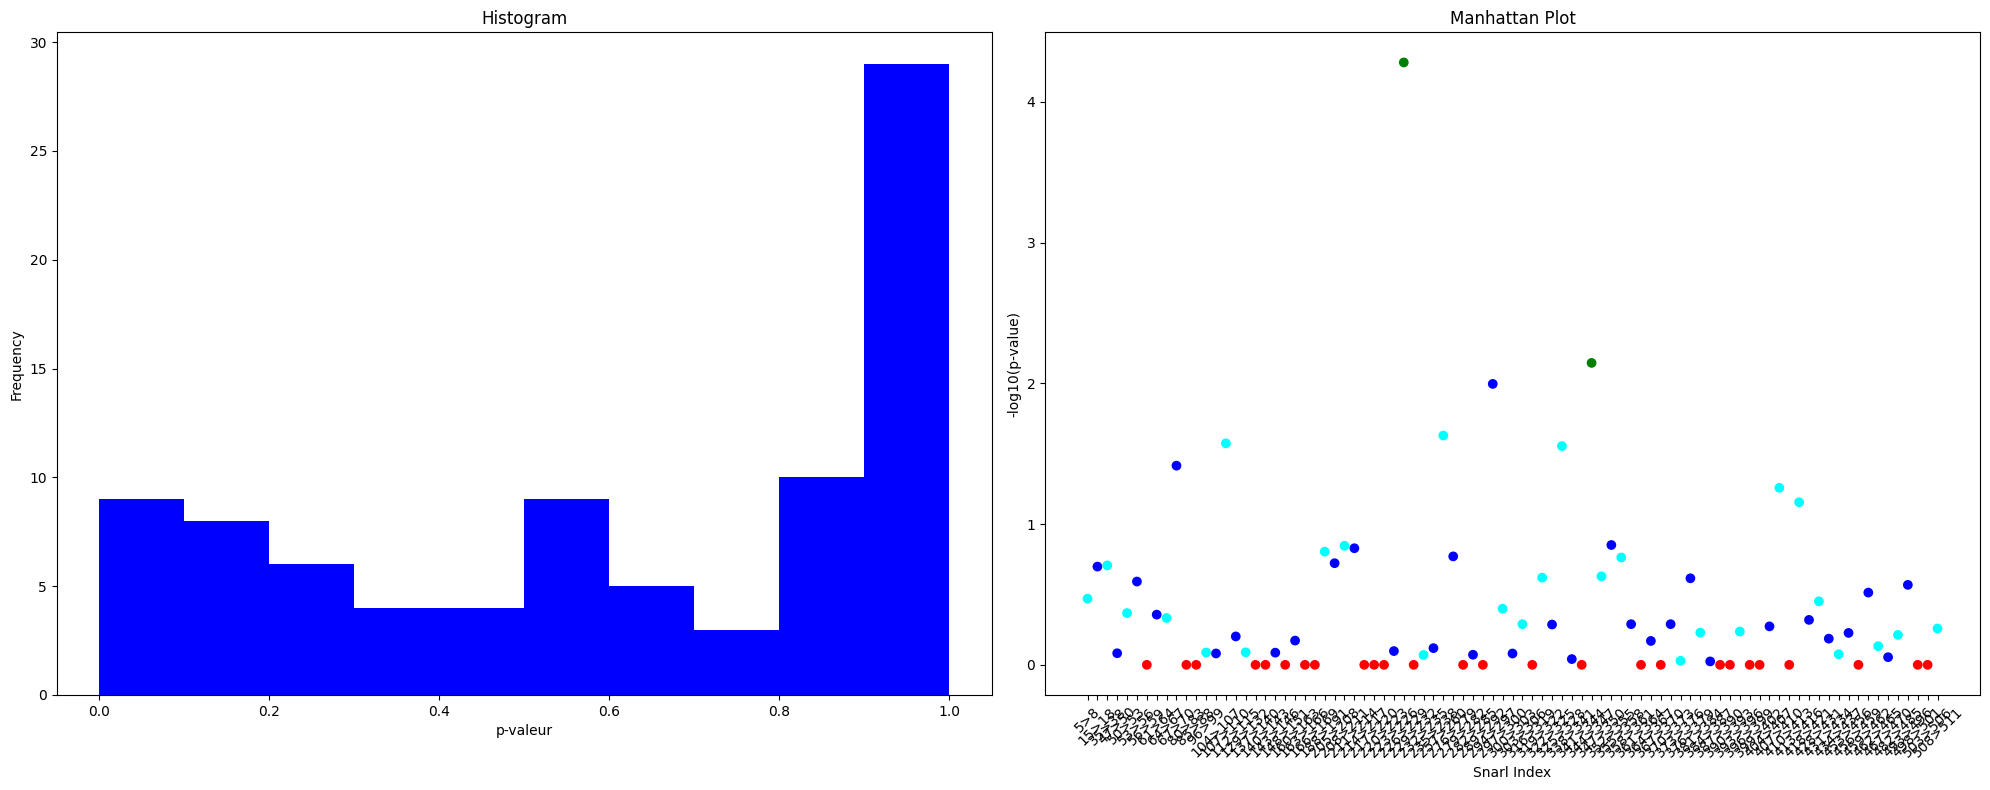

In [23]:
# histograms and manhattan plots

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# histogram
axs[0].hist(pval_df_bdsg['p-valeur'], color='blue')
axs[0].set_title('Histogram')
axs[0].set_xlabel('p-valeur')  # Add x-axis label for the histogram
axs[0].set_ylabel('Frequency')

# manhattan plot
axs[1].scatter(range(len(pval_df_bdsg)), pval_df_bdsg['moinslog10pvaleur'], c=pval_df_bdsg['color'])
axs[1].set_title('Manhattan Plot')
axs[1].set_xlabel('Snarl Index')
axs[1].set_ylabel('-log10(p-value)')

# customize x-axis for the manhattan plot
axs[1].set_xticks(range(len(pval_df_bdsg)))
axs[1].set_xticklabels(pval_df_bdsg.index, rotation=45)

# Adjust layout
plt.tight_layout()

TypeError: manhattan_plot() takes 1 positional argument but 2 were given

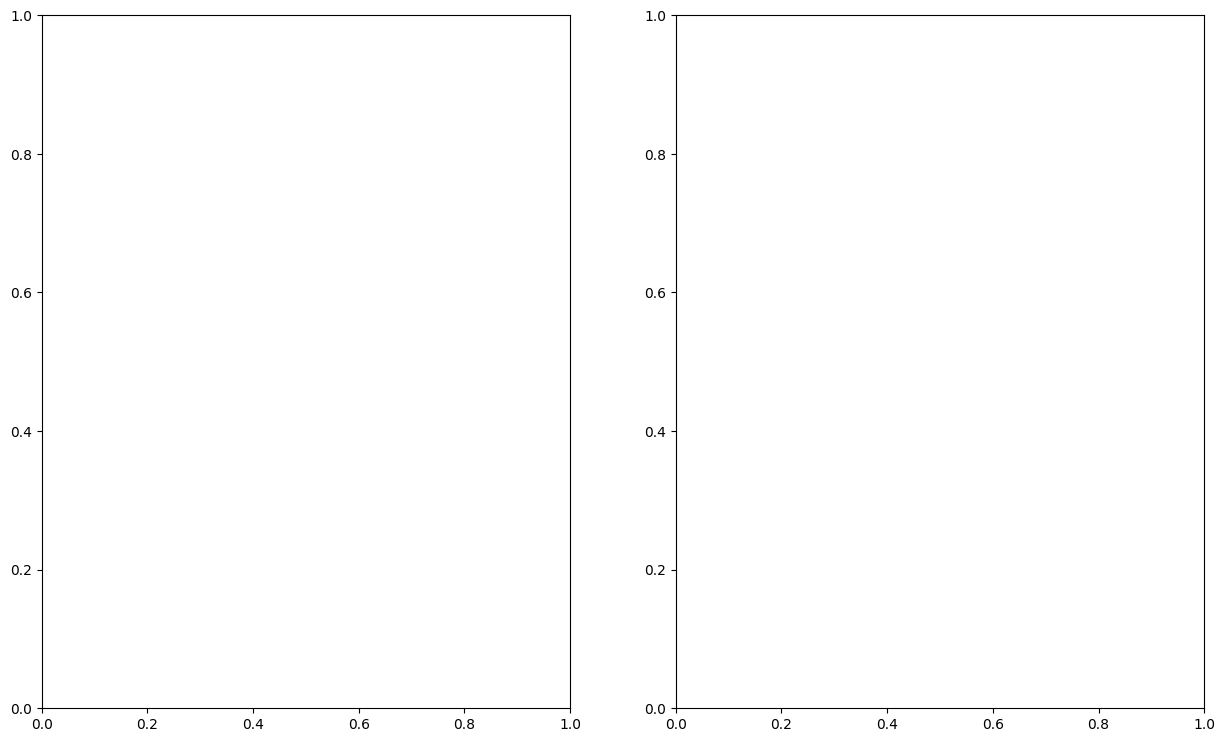

In [30]:
def manhattan_plot(which_pv_df, ax):
    ax.scatter(range(len(which_pv_df)), which_pv_df['moinslog10pvaleur'], c=which_pv_df['color'])
    
    # Customize x-axis
    ax.set_xticks(range(len(which_pv_df)))
    ax.set_xticklabels(which_pv_df.index, rotation=90, size=10)
    ax.set_xlabel('snarl index')
    ax.set_ylabel('-log10(p-value)')
    ax.set_title('manhattan plot')
    
    # Adjust tick labels' vertical position for readability
    for i, label in enumerate(ax.get_xticklabels()):
        label.set_color(which_pv_df['color'].iloc[i])
        if i % 2 == 0:
            label.set_y(-0.05)
        else:
            label.set_y(-0.02)


def histogram(which_pv_df, ax):
    ax.hist(which_pv_df['p-valeur'], color='blue')
    ax.set_title('Histogram')
    ax.set_xlabel('p-valeur')
    ax.set_ylabel('Frequency')


fig, axs = plt.subplots(1, 2, figsize=(15, 9))

manhattan_plot(which_pv_df, axs[0])
histogram(which_pv_df, axs[1])

plt.tight_layout()
plt.show()

# Example usage:
# plot_side_by_side(your_dataframe)


In [25]:
# generate a tsv file with the results of the tests

'''pval_df_comp_chi2 = pval_df_comp_chi2.drop(columns='color')
pval_df_part_chi2 = pval_df_part_chi2.drop(columns='color')
pval_df_comp_chi2.to_csv('pval_full_paths', sep='\t', index=True, header=True)
pval_df_part_chi2.to_csv('pval_partial_paths', sep='\t', index=True, header=True)'''

"pval_df_comp_chi2 = pval_df_comp_chi2.drop(columns='color')\npval_df_part_chi2 = pval_df_part_chi2.drop(columns='color')\npval_df_comp_chi2.to_csv('pval_full_paths', sep='\t', index=True, header=True)\npval_df_part_chi2.to_csv('pval_partial_paths', sep='\t', index=True, header=True)"